The data for the given problem is stored in a JSON format.
We first read this data from the file and copy the contents to local variables with more convenient names.

In [31]:
import numpy as np
import json # For the purposes of loading data

with open('instance_data.json', 'r') as f:
    params_dict = json.load(f)

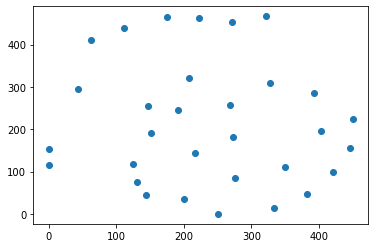

In [32]:
import matplotlib.pyplot as plt
plt.plot(params_dict["X"],params_dict["Y"],"o")

In [33]:
n = params_dict['num_nodes'] # number of nodes in graph

nodes = range(1, n + 1) # nodes will be indexed 1,...,n (unlike usually Python indexing)
edges = [tuple(l) for l in params_dict['links']] # links in network

# Pairs of nodes/customers which have communication demand between them
demand_pairs = [tuple(p) for p in params_dict['demand_pairs']] 

# List of mean demand for each demand pair (in same order of demand_pairs)
demand_mean = params_dict['demand_ms'] # Distribution is Gamma(μ, 1/μ) (where second parameter is scale rather than rate)


# Routes gives set of valid routes for each demand pair
# routes[i] gives the set of the routes for the i-th demand pair
# and each route is defined by a set of edges
routes_list = params_dict['routes']
routes=[]
for (i, p) in enumerate(demand_pairs):
    routes.append([])
    for rs in routes_list[i]:
        routes[i].append([edges[l-1] for l in rs])

# List containing existing capacity for each link/edge
e = params_dict['existing_capacity']
# Maximum total additional capacity
b = params_dict['total_extra_capacity']

In [34]:
print(demand_pairs[0])
print(routes[0])

(25, 31)
[[(19, 25), (19, 31)], [(17, 25), (17, 19), (19, 31)], [(19, 25), (5, 19), (5, 31)]]


The following cell defines a function for sampling sets of scenarios. Note that demand has a Gamma distribution and takes as input the means of the Gamma distribution and the number of required scenarios. It returns the scenario set as a list of vectors.

In [35]:
from scipy.stats import gamma
from typing import List

def sample_scenarios(num_scen : int, demand_mean : List[float]) -> List[np.array]:
    scen_set = []
    for s in range(num_scen):
        #scen = gamma.rvs(np.array(demand_mean), scale=1/np.array(demand_mean))
        scen=np.array([gamma.rvs(mu, 1/mu) for mu in demand_mean])
        scen_set.append(scen)
    return scen_set

In [78]:
sample_scenarios(1,[1,10])

[array([1.65763085, 7.99876616])]

The following function implements the recourse function (denoted `h(x,d)` in the paper).

In [106]:
from gurobipy import Model, GRB, tupledict, quicksum

def solve_tnp_recourse(edges, x, e, demand_pairs, routes, demand_scenario):
    m = Model()

    m.Params.outputFlag=0 # Change to 1 if you want to see output from Gurobi

    num_edges = len(edges)
    num_dem_pairs = len(demand_pairs)
    num_routes = [len(r) for r in routes]

    # Second stage
    f = tupledict()
    for i in range(num_dem_pairs):
        for ri in range(num_routes[i]):
            f[i,ri] = m.addVar(name='f[{},{}]'.format(i, ri))
                
    dem_unsat = m.addVars(num_dem_pairs)
    for (li, l) in enumerate(edges):
        edge_flow = quicksum(f[i,ri] for i in range(num_dem_pairs)
                             for (ri, r) in enumerate(routes[i]) if l in r)
        m.addConstr(edge_flow <= x[li] + e[li])

    for i in range(num_dem_pairs):
        total_flow = quicksum(f[i,ri] for ri in range(num_routes[i]))
        m.addConstr(total_flow + dem_unsat[i] == demand_scenario[i])
            
    m.setObjective(quicksum(dem_unsat[i] for i in range(num_dem_pairs)), GRB.MINIMIZE)
    
    m.optimize()
    return m.objVal, m.getAttr('x', f)

## Deterministic Equivalent

In [107]:
def add_scenario(m,x,f,s, edges,e, num_dem_pairs, routes, new_scenario, ind):
    # ind is scenario index
    num_edges = len(edges) 
    num_routes = [len(r) for r in routes]
    
    #Scenario variables
    for i in range(num_dem_pairs):
        for ri in range(num_routes[i]):
            f[i,ri,ind] = m.addVar(name='f[{},{},{}]'.format(i, ri,ind))
                
    for i in range(num_dem_pairs):
        s[i,ind] = m.addVar(name="s[{},{}]".format(i,ind))
    
    #Scenrario constraints
    for (li, l) in enumerate(edges):
        edge_flow = quicksum(f[i,ri,ind] for i in range(num_dem_pairs)
                             for (ri, r) in enumerate(routes[i]) if l in r)
        m.addConstr(edge_flow <= x[li] + e[li])

    for i in range(num_dem_pairs):
        total_flow = quicksum(f[i,ri,ind] for ri in range(num_routes[i]))
        m.addConstr(total_flow + s[i,ind] == new_scenario[i])

In [ ]:
def solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, total_capacity):
    m = Model()

    m.Params.outputFlag=0 # Change to 1 if you want to see output from Gurobi

    num_edges = len(edges) # n
    num_dem_pairs = len(demand_pairs) # m
    num_routes = [len(r) for r in routes] #the sum of this list is p
    
    x = m.addVars(num_edges)
    m.addConstr(quicksum(x[i] for i in range(num_edges)) <= total_capacity )
    
    f = dict() # decision variable f_irs
    s = dict() # decision variable s_is
    for ind,scenario in enumerate(demand_scenarios):
        add_scenario(m,x,f,s, edges,e, num_dem_pairs, routes, scenario, ind)

    N = len(demand_scenarios)
    m.setObjective(quicksum(s[i,ind]/N for i in range(num_dem_pairs) for ind in range(N) ), GRB.MINIMIZE)
    m.optimize()
    return m.objVal, m.getAttr('x', x)

In [ ]:
np.random.seed(1)

# for N in range(200,1001,200):
N = 1000 
demand_scenarios = sample_scenarios(N, demand_mean)
opt_val, opt_x = solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)
print("Optimal value for N={} is {}".format(N,opt_val))

In [108]:
def out_of_sample_estimate(demand_scenarios,*args):
    G = 0
    for scenario in demand_scenarios:
        opt_val,_ = solve_tnp_recourse(demand_scenario=scenario, *args)
        G += opt_val
    return G/len(demand_scenarios)

In [134]:
from scipy.stats import t

def optimality_gap(n,m,x_tilde,method):
    z_n = np.zeros(m)
    G_n = np.zeros(m)

    for i in range(m):
        print(".",end="")
        demand_scenarios = method(n, demand_mean)
        z_n[i], _ =  solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)
        G_n[i]    =  out_of_sample_estimate(demand_scenarios,edges, x_tilde , e, demand_pairs, routes)
    G_n  -= z_n
    print()
    return G_n 

def extract_statistics(G_n):
    sd = np.std(G_n)
    upper_bound = np.mean(G_n)+t.ppf(0.95, m-1)/np.sqrt(m)*sd

    return np.mean(G_n),upper_bound

In [135]:
## Estimate of optimality gap with N=1000 
x_tilde = opt_x
n=20
m=30
np.random.seed(1)
G_n = optimality_gap(n,m,x_tilde,sample_scenarios)
print(extract_statistics(G_n))

..............................
(3.7357507280417397, 3.977624891992375)


In [133]:
optimality_Gaps = list()
upper_bounds = list()

np.random.seed(1)
n_vals = np.concatenate((np.linspace(5,50,10),np.linspace(60,100,5)))

#Basic Monte Carlo 
for n in n_vals:   
    print("n=",n)
    G_n = optimality_gap(n,m,x_tilde,sample_scenarios)
    gap , ub = extract_statistics(G_n)
    optimality_Gaps.append(gap)
    upper_bounds.append(ub)

n= 5
..............................
n= 10
..............................
n= 15
..............................
n= 20
..............................
n= 25
..............................
n= 30
..............................
n= 35
..............................
n= 40
..............................
n= 45
..............................
n= 50
..............................


In [ ]:
def sample_scenarios_antithetical(num_scen, demand_mean):
    scen_set = []
    uniform_sample = np.random.random(num_scen//2)
    def append_scenario(u):
        scen=np.array([ gamma.ppf(u,a=mu,loc=1/mu) for mu in demand_mean])
        scen_set.append(scen)
    for u in uniform_sample:
        append_scenario(u)
        append_scenario(1-u)
    if num_scen%2:  append_scenario(np.random.uniform())
    
    return scen_set

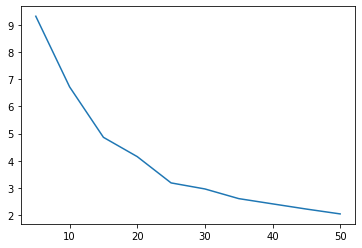

In [137]:
plt.plot(n_vals,optimality_Gaps)

In [ ]:
plt.errorbar(n_vals,optimality_Gaps)

In [58]:
# Example usage

## Sample scenario
np.random.seed(1)
N=1
scen = sample_scenarios(N, demand_mean)[0]

for i in range(5):
    print("Demand pair", demand_pairs[i], "has demand", scen[i])

    
# Construct a first stage solution : no increase in capacity for any link
x = [0 for i in range(len(edges))]

# Solve recourse problem
opt_val, opt_flows = solve_tnp_recourse(edges, x, e, demand_pairs, routes, scen)
print("Recourse function value is:", opt_val)

Demand pair (25, 31) has demand 33.6855269184297
Demand pair (27, 28) has demand 21.791386218756585
Demand pair (2, 31) has demand 22.1753624080385
Demand pair (3, 22) has demand 19.75225133646571
Demand pair (4, 8) has demand 34.42677128623564
Recourse function value is: 1572.2825001649219


In [59]:
opt_flows

{(0, 0): 0.0,
 (0, 1): 0.0,
 (0, 2): 0.0,
 (1, 0): 0.0,
 (1, 1): 0.0,
 (1, 2): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 0.0,
 (2, 3): 0.0,
 (2, 4): 0.0,
 (2, 5): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (3, 3): 0.0,
 (3, 4): 0.0,
 (3, 5): 0.0,
 (3, 6): 0.0,
 (3, 7): 0.0,
 (3, 8): 0.0,
 (3, 9): 0.0,
 (3, 10): 0.0,
 (3, 11): 1.115946996563686,
 (3, 12): 0.0,
 (3, 13): 0.0,
 (4, 0): 10.0,
 (4, 1): 10.0,
 (4, 2): 0.0,
 (4, 3): 3.0569469122348227,
 (4, 4): 0.0,
 (4, 5): 0.0,
 (4, 6): 0.0,
 (4, 7): 0.0,
 (4, 8): 0.0,
 (4, 9): 0.0,
 (4, 10): 0.0,
 (4, 11): 0.0,
 (4, 12): 0.0,
 (4, 13): 0.0,
 (4, 14): 0.0,
 (4, 15): 0.0,
 (4, 16): 0.0,
 (4, 17): 0.0,
 (4, 18): 0.0,
 (4, 19): 0.0,
 (4, 20): 0.0,
 (4, 21): 0.0,
 (4, 22): 0.0,
 (5, 0): 10.0,
 (5, 1): 1.115946996563686,
 (5, 2): 10.0,
 (5, 3): 0.0,
 (5, 4): 0.0,
 (5, 5): 0.0,
 (5, 6): 0.0,
 (5, 7): 0.0,
 (5, 8): 0.0,
 (5, 9): 0.0,
 (5, 10): 0.0,
 (5, 11): 0.0,
 (5, 12): 0.0,
 (5, 13): 0.0,
 (5, 14): 0.0,
 (5, 15): 0.0,
 (5, 16): 0.0,
 (5, 